In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch.nn import Linear, Dropout, BatchNorm1d
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional

In [2]:
classes_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_classes.csv"
edges_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_edgelist.csv"
features_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)

# Preprocess the classes DataFrame
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))

# Create a mapping for all nodes
all_nodes_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

# Create edges list with all nodes
edges_list = [
    (all_nodes_dict[edges['txId1'][i]], all_nodes_dict[edges['txId2'][i]])
    for i in tqdm(range(len(edges)))
    if edges['txId1'][i] in all_nodes_dict and edges['txId2'][i] in all_nodes_dict
]
edge_index = torch.tensor(edges_list, dtype=torch.long).T

# Convert node features and labels    Parameter to (V) choose features used
#node_features = torch.tensor(df.iloc[:, 1:].values, dtype=torch.float)
time_step = torch.tensor(df['time_step'].values, dtype=torch.float)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.iloc[:, 2:].values)  # Exclude txId and time_step

# Combine time_step back with scaled features
node_features = torch.cat((time_step.unsqueeze(1), torch.tensor(scaled_features, dtype=torch.float)), dim=1)

label_mapping = {'1': 0, '2': 1, 'unknown': -1} 
labels = torch.tensor(classes['label'].map(label_mapping).values, dtype=torch.long)

# Create graph data object
data = Data(x=node_features, edge_index=edge_index, y=labels)

#device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
data.to(device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234355/234355 [00:01<00:00, 180288.06it/s]


cpu


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769])

In [3]:
#time_step_column_index = 0 
#time_step = data.x[:, time_step_column_index]

#train_mask = (time_step >= 1) & (time_step <= 34)
#test_mask = (time_step >= 35) & (time_step <= 49)

#train_mask = train_mask.clone().detach().to(torch.bool)
#test_mask = test_mask.clone().detach().to(torch.bool)

In [4]:
train_mask = (time_step >= 1) & (time_step <= 29)
val_mask = (time_step >= 30) & (time_step <= 34)
test_mask = (time_step >= 35) & (time_step <= 49)

# Ensure the masks are boolean tensors
train_mask = train_mask.clone().detach().to(torch.bool)
val_mask = val_mask.clone().detach().to(torch.bool)
test_mask = test_mask.clone().detach().to(torch.bool)

In [5]:
num_features = data.x.shape[1]  # Number of features (columns in x)
num_classes = 2  # Number of classes (2 in this case)
heads = 2
#Hyperparameters
embeddings_length = 128
lr = 0.001
weight_decay = 0.002
epochs = 501

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


class GAT(torch.nn.Module):
    def __init__(self, in_channels, embeddings_length, heads, num_classes):
        super().__init__()
        self.gat= GATConv(in_channels=in_channels, out_channels=embeddings_length, heads=heads)
        self.out = Linear(embeddings_length * heads, num_classes)
        self.dropout = Dropout(p=0.3)
    
    def forward(self, x, edge_index):
        h = self.gat(x, edge_index)
        h = torch.nn.functional.leaky_relu(h)
        h = self.dropout(h)
        z = self.out(h)
        return h, z

# Initialize the model
num_features = data.x.shape[1]  # Number of features (columns in x)
num_classes = 2  # Number of classes (2 in this case)
embeddings_length = 128
heads = 2
model = GAT(num_features, embeddings_length, heads, num_classes).to(device)
print(model)
print(num_classes)

# Loss function and optimizer

valid_labels = classes['label'].map(label_mapping)
valid_labels = valid_labels[valid_labels != -1]  # Exclude 'unknown'

# Convert to a PyTorch tensor for use in the loss function
class_weights_tensor = torch.tensor([0.7, 0.3], dtype=torch.float).to(device)

# Define the loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor).to(device)

#criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Accuracy calculation function
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)  # h: embeddings, z: logits

    # Exclude unlabeled nodes from the loss calculation
    mask = data.y[train_mask] != -1  
    loss = criterion(z[train_mask][mask], data.y[train_mask][mask]) # Compute loss
    
    loss.backward()                         # Backpropagate
    optimizer.step()                        # Update model parameters

    acc = accuracy(z[train_mask].argmax(dim=1)[mask], data.y[train_mask][mask])  # Calculate accuracy

    model.eval() 
    with torch.no_grad():
        mask_val = data.y[val_mask] != -1  
        val_loss = criterion(z[val_mask][mask_val], data.y[val_mask][mask_val])
        val_acc = accuracy(z[val_mask].argmax(dim=1)[mask_val], data.y[val_mask][mask_val])

    train_losses.append(loss.item())
    train_accuracies.append(acc.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_acc.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%%')


GAT(
  (gat): GATConv(166, 128, heads=2)
  (out): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
2
Epoch   0 | Loss: 0.73 | Acc: 59.66 | Val Loss: 0.8070 | Val Acc: 49.81%%
Epoch  10 | Loss: 0.32 | Acc: 91.04 | Val Loss: 0.4535 | Val Acc: 81.92%%
Epoch  20 | Loss: 0.27 | Acc: 90.55 | Val Loss: 0.4572 | Val Acc: 73.93%%
Epoch  30 | Loss: 0.24 | Acc: 92.73 | Val Loss: 0.3826 | Val Acc: 81.38%%
Epoch  40 | Loss: 0.22 | Acc: 92.89 | Val Loss: 0.3770 | Val Acc: 80.39%%
Epoch  50 | Loss: 0.20 | Acc: 93.67 | Val Loss: 0.3532 | Val Acc: 81.90%%
Epoch  60 | Loss: 0.19 | Acc: 94.22 | Val Loss: 0.3395 | Val Acc: 82.47%%
Epoch  70 | Loss: 0.18 | Acc: 94.42 | Val Loss: 0.3315 | Val Acc: 82.69%%
Epoch  80 | Loss: 0.17 | Acc: 94.94 | Val Loss: 0.3167 | Val Acc: 83.75%%
Epoch  90 | Loss: 0.16 | Acc: 95.21 | Val Loss: 0.3065 | Val Acc: 84.20%%
Epoch 100 | Loss: 0.15 | Acc: 95.49 | Val Loss: 0.2968 | Val Acc: 84.97%%
Epoch 110 | Loss: 0.15 | Acc: 95.67 | 

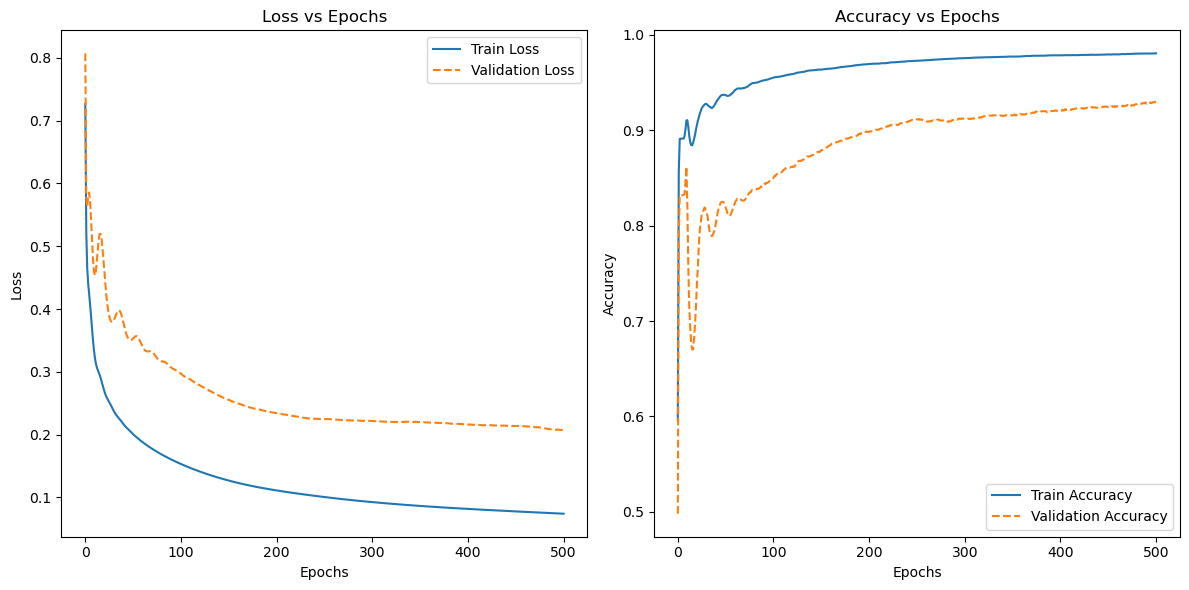

In [6]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Extract node embeddings
model.eval()
with torch.no_grad():
    embeddings, _ = model(data.x, data.edge_index)  # h: embeddings

# Ensure alignment of txId and labels with embeddings
# The order in `data.x` corresponds to `classes['txId']` due to how `all_nodes_dict` was built
aligned_df = pd.DataFrame({
    'txId': classes['txId'],  # Use the original node order
    'time_step': time_step.cpu().numpy(),  # Extract time_step from the gat input
    'label': classes['label']  # Use the original labels
})

# Add embeddings
embeddings_df = pd.concat([aligned_df, pd.DataFrame(embeddings.cpu().numpy())], axis=1)

# Save to CSV
embeddings_df.to_csv('../data/embeddings_gat.csv', index=False)

In [8]:
embeddings_df.drop(embeddings_df[embeddings_df["label"] == "unknown"].index, inplace=True)
y = embeddings_df['label']
X = embeddings_df.drop(columns=['label'])

In [9]:
X_train_gat = X[X['time_step'].between(1, 34)]
y_train_gat = y[X['time_step'].between(1, 34)]

X_test_gat = X[X['time_step'].between(35, 49)]
y_test_gat = y[X['time_step'].between(35, 49)]

X_train_gat = X_train_gat.drop(columns=['time_step','txId'])
X_test_gat = X_test_gat.drop(columns=['time_step','txId'])

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score

clf_gat = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_gat.fit(X_train_gat, y_train_gat)
y_pred_gat = clf_gat.predict(X_test_gat)

precision_ilicit_gat = precision_score(y_test_gat, y_pred_gat, pos_label='1')
recall_ilicit_gat = recall_score(y_test_gat, y_pred_gat, pos_label='1')
f1_ilicit_gat = f1_score(y_test_gat, y_pred_gat, pos_label='1')
f1_scorer_gat = make_scorer(f1_score, pos_label='1')
scores_gat = cross_val_score(clf_gat, X_train_gat, y_train_gat, cv=5, scoring=f1_scorer_gat)

print(f'Precision node embeddings (gat): {precision_ilicit_gat}')
print(f'Recall node embeddings (gat): {recall_ilicit_gat}')
print(f'F1 node embeddings (gat): {f1_ilicit_gat}')
print("Cross-validated F1 Score node embeddings (gat):", scores_gat.mean())

Precision node embeddings (gat): 0.7912457912457912
Recall node embeddings (gat): 0.2169898430286242
F1 node embeddings (gat): 0.34057971014492755
Cross-validated F1 Score node embeddings (gat): 0.4150526303436278
